In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense

In [27]:
# Import main data and get list of SMILES
molecules = pd.read_csv('./fathead_minnow_dataset.csv')  # Load the photoswitch dataset using pandas
smiles_list = list(molecules.SMILES.values)

In [28]:
len(smiles_list)

554

In [29]:
# Initiate list of rdkit molecules
rdkit_mols = [MolFromSmiles(smiles) for smiles in smiles_list]

In [30]:
# Get Morgan fingerprints, note the parameters!
morgan_fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius = 3, nBits = 2048) for mol in rdkit_mols]
morgan_fingerprints = np.asarray(morgan_fingerprints)

In [44]:
# Turn into pandas dataframe and add smiles as a first column
morgan_fingerprints = pd.DataFrame(data = morgan_fingerprints)
morgan_fingerprints.insert(0, 'SMILES', smiles_list)

In [52]:
morgan_fingerprints

,SMILES,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,N#CCC#N,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C1COCCO1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CN(C)N,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C1=CC=CC(O)=C1C(=O)OC2=CC=CC=C2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ClCCCCl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,C1=CC=CC=C1CCCCC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550,CN(C)C1=CC=C(C=O)C=C1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
551,C1=C(N)C=CC=C1OCC2=CC=CC=C2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
552,CC(C)SSC(C)C,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
morgan_fingerprints.duplicated().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0      False
1      False
2      False
3      False
4      False
       ...  
549    False
550    False
551    False
552    False
553    False
Length: 554, dtype: bool>

In [12]:
morgan_fingerprints.to_csv('morgan_fingerprints.csv')

In [13]:
# Next, rdkit's own descriptors
from rdkit.Chem import Descriptors

In [14]:
# A list of desriptors
Descriptors.descList

[('MaxEStateIndex',
  <function rdkit.Chem.EState.EState.MaxEStateIndex(mol, force=1)>),
 ('MinEStateIndex',
  <function rdkit.Chem.EState.EState.MinEStateIndex(mol, force=1)>),
 ('MaxAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MaxAbsEStateIndex(mol, force=1)>),
 ('MinAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MinAbsEStateIndex(mol, force=1)>),
 ('qed',
  <function rdkit.Chem.QED.qed(mol, w=QEDproperties(MW=0.66, ALOGP=0.46, HBA=0.05, HBD=0.61, PSA=0.06, ROTB=0.65, AROM=0.48, ALERTS=0.95), qedProperties=None)>),
 ('MolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('HeavyAtomMolWt', <function rdkit.Chem.Descriptors.HeavyAtomMolWt(x)>),
 ('ExactMolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('NumValenceElectrons',
  <function rdkit.Chem.Descriptors.NumValenceElectrons(mol)>),
 ('NumRadicalElectrons',
  <function rdkit.Chem.Descriptors.NumRadicalElectrons(mol)>),
 ('MaxPartialCharge',
  <function rdkit.Chem.Descriptors.MaxPartialCharge(mo

In [15]:
# Write a dictionary of name:function pairs for all descriptors
all_descriptors = {d[0]: d[1] for d in Descriptors.descList}

In [16]:
# Initialise a new pandas df
rdkit_descriptors = pd.DataFrame(data = {'SMILES': np.array((smiles_list)) })
rdkit_descriptors

,SMILES
0,N#CCC#N
1,C1COCCO1
2,CN(C)N
3,C1=CC=CC(O)=C1C(=O)OC2=CC=CC=C2
4,ClCCCCl
...,...
549,C1=CC=CC=C1CCCCC
550,CN(C)C1=CC=C(C=O)C=C1
551,C1=C(N)C=CC=C1OCC2=CC=CC=C2
552,CC(C)SSC(C)C


In [31]:
# Compute each descriptor (outer loop) for each molecule(inside)
for feature in all_descriptors:
    values = []
    for mol in rdkit_mols:
        values += [all_descriptors[feature](mol)]
    rdkit_descriptors[feature] = values

rdkit_descriptors

,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,N#CCC#N,7.593750,0.000000,7.593750,0.000000,0.411164,66.063,64.047,66.021798,24,...,0,0,0,0,0,0,0,0,0,0
1,C1COCCO1,4.944444,0.777778,4.944444,0.777778,0.415749,88.106,80.042,88.052429,36,...,0,0,0,0,0,0,0,0,0,0
2,CN(C)N,4.944444,1.500000,4.944444,1.500000,0.299219,60.100,52.036,60.068748,26,...,0,0,0,0,0,0,0,0,0,0
3,C1=CC=CC(O)=C1C(=O)OC2=CC=CC=C2,11.652689,-0.565463,11.652689,0.080156,0.617037,214.220,204.140,214.062994,80,...,0,0,0,0,0,0,0,0,0,0
4,ClCCCCl,5.217207,0.684028,5.217207,0.684028,0.479095,112.987,106.939,111.984656,32,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,C1=CC=CC=C1CCCCC,2.241065,1.244722,2.241065,1.244722,0.573822,148.249,132.121,148.125201,60,...,0,0,0,0,0,0,0,0,1,0
550,CN(C)C1=CC=C(C=O)C=C1,10.274032,0.718148,10.274032,0.718148,0.594673,149.193,138.105,149.084064,58,...,0,0,0,0,0,0,0,0,0,0
551,C1=C(N)C=CC=C1OCC2=CC=CC=C2,5.647557,0.573704,5.647557,0.573704,0.771297,199.253,186.149,199.099714,76,...,0,0,0,0,0,0,0,0,0,0
552,CC(C)SSC(C)C,2.222269,0.766111,2.222269,0.766111,0.566681,150.312,136.200,150.053692,50,...,0,0,0,0,0,0,0,0,0,0


In [18]:
rdkit_descriptors.to_csv('rdkit_descriptors.csv')

E:\Anaconda 23-09-2022\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='qed', ylabel='count'>

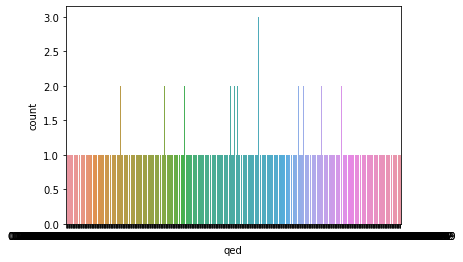

In [71]:
rdkit_descriptors.duplicated().sum
sns.countplot(rdkit_descriptors['qed'])

In [58]:
rdkit_descriptors['SMILES'].unique()

array(['N#CCC#N', 'C1COCCO1', 'CN(C)N', 'C1=CC=CC(O)=C1C(=O)OC2=CC=CC=C2',
       'ClCCCCl', 'CCC(O)(C)CC', 'NC1=CC=C(F)C=C1', 'CCC(O)=O',
       'C1(Cl)=CC=CC(Cl)=C1C(=O)N', 'O=[N+](C1=CC=CC=C1)[O-]',
       'CC(=O)C(C)(C)C', 'ClC(Cl)C1=C(Cl)C=CC=C1Cl',
       'C1=CC(C=O)=CC(OC)=C1OCCCCCC', 'C(Cl)(Cl)(Cl)CO', 'CCC1=CC=CC=C1',
       'CC2(C)OC1(C)CCC2CC1', 'C1=CC=CC(O)=C1C(=O)OCC',
       'CC1=C(C=CC(=C1)C)C', 'C1(C=O)=C(O)C(OC)=CC=C1', 'C1=CC=CC=C1',
       'O=C(OC1=C2C(=CC=C1)C=CC=C2)NC', 'OC1=CC=C(Cl)C=C1',
       'ClC1=C(C=CC=C1)Cl', 'C1(Cl)=CC=C(Cl)C=C1C(=O)OC',
       'C1(C=O)=CC=C(C(C)C)C=C1', 'FC1=CC=C([N+](=O)[O-])C=C1',
       'CC(C)(O)C(F)(C(F)F)F',
       'O=C([C@](C(C=C4OC)=C(C=C4OC)OC3)([H])[C@]3([H])O2)C(C=C5)=C2C1=C5O[C@@H]([C@@](C)=C)C1',
       'CC(=O)CCC(C)C', 'OC(C)CC#C', 'C1=CC=CC=C1OC2=CC=C(O)C=C2',
       'C1(=CC=CC=C1)C(=O)O', 'C1=CC=CC=C1C(=O)N', 'NCC1=CC=CC=C1',
       'C1C(=O)N(CC)C(=S)N(CC)C1=O', 'C1(=CC=C(C=C1)O)NC(C)=O', 'BrCCCBr',
       'O1C(C)=CC=C1C', 

E:\Anaconda 23-09-2022\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='qed', ylabel='count'>

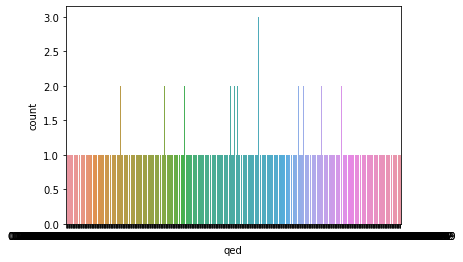

In [72]:
sns.countplot(rdkit_descriptors['qed'])

In [64]:
rdkit_descriptors.isnull().sum()

SMILES               0
MaxEStateIndex       0
MinEStateIndex       0
MaxAbsEStateIndex    0
MinAbsEStateIndex    0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 209, dtype: int64

In [67]:
rdkit_descriptors.dtypes

SMILES                object
MaxEStateIndex       float64
MinEStateIndex       float64
MaxAbsEStateIndex    float64
MinAbsEStateIndex    float64
                      ...   
fr_thiazole            int64
fr_thiocyan            int64
fr_thiophene           int64
fr_unbrch_alkane       int64
fr_urea                int64
Length: 209, dtype: object

<AxesSubplot:>

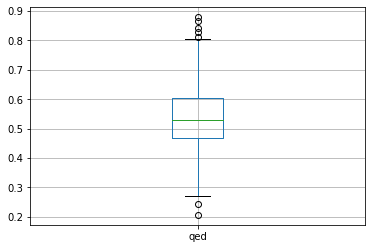

In [76]:
rdkit_descriptors[['qed']].boxplot()

In [77]:
rdkit_descriptors.corr()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
MaxEStateIndex,1.000000,-0.637228,1.000000,-0.645460,0.181542,0.357921,0.359878,0.360047,0.464742,NaN,...,-0.195874,0.040733,NaN,-0.003141,NaN,-0.034636,NaN,-0.069426,-0.106857,0.090118
MinEStateIndex,-0.637228,1.000000,-0.637228,0.342910,-0.060516,-0.322535,-0.337893,-0.323358,-0.347789,NaN,...,0.116383,-0.152937,NaN,-0.074498,NaN,0.029184,NaN,0.048575,0.120731,-0.073671
MaxAbsEStateIndex,1.000000,-0.637228,1.000000,-0.645460,0.181542,0.357921,0.359878,0.360047,0.464742,NaN,...,-0.195874,0.040733,NaN,-0.003141,NaN,-0.034636,NaN,-0.069426,-0.106857,0.090118
MinAbsEStateIndex,-0.645460,0.342910,-0.645460,1.000000,-0.154612,-0.256051,-0.260522,-0.256367,-0.271109,NaN,...,0.180126,-0.038801,NaN,0.024874,NaN,0.024201,NaN,0.068041,0.145534,-0.033475
qed,0.181542,-0.060516,0.181542,-0.154612,1.000000,0.425589,0.421371,0.425840,0.402377,NaN,...,-0.054281,0.030548,NaN,-0.050918,NaN,0.040292,NaN,0.003457,-0.157494,0.097972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fr_thiazole,-0.034636,0.029184,-0.034636,0.024201,0.040292,0.025723,0.030733,0.025568,-0.003344,NaN,...,-0.005720,-0.001808,NaN,-0.005972,NaN,1.000000,NaN,-0.001808,-0.014671,-0.003626
fr_thiocyan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fr_thiophene,-0.069426,0.048575,-0.069426,0.068041,0.003457,0.001719,0.006834,0.001243,-0.048614,NaN,...,-0.005720,-0.001808,NaN,-0.005972,NaN,-0.001808,NaN,1.000000,-0.014671,-0.003626
fr_unbrch_alkane,-0.106857,0.120731,-0.106857,0.145534,-0.157494,0.107590,0.059085,0.108840,0.236874,NaN,...,0.262826,-0.014671,NaN,-0.042301,NaN,-0.014671,NaN,-0.014671,1.000000,-0.029422


In [33]:
pip install mordred

  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=1644c45bf401dfb066aca2e39a33cc70a1d05b55b1e64d3778f0dc5a8e929370
  Stored in directory: c:\users\drago\appdata\local\pip\cache\wheels\05\95\d1\9e913738f0e8362b3676917b953a60afd76d2b0b99ff8a71ec
Successfully built mordred
Note: you may need to restart the kernel to use updated packages.


In [34]:
# Finally, mordred descriptors
from mordred import Calculator, descriptors, error

In [35]:
# Initialise a calculator -- mordred works weirdly this way...
calc = Calculator(descriptors)

In [36]:
# Wow, many descriptors, much wow
len(calc.descriptors)

1826

In [37]:
mordred_descriptors = calc.pandas(rdkit_mols)

100%|████████████████████████████████████████████████████████████████████████████████| 554/554 [00:16<00:00, 32.70it/s]


In [38]:
# It seems that unfortunately some descriptors cannot be computed. To filter this, 
# we find all columns that are of data type "object", since those contain non-numerical values usually.
error_columns = []
for i, e in enumerate(mordred_descriptors.dtypes):
    if e == 'object':
        error_columns += [i]
error_columns

[137,
 138,
 139,
 140,
 141,
 142,
 146,
 147,
 148,
 149,
 150,
 151,
 155,
 156,
 157,
 158,
 159,
 160,
 164,
 165,
 166,
 167,
 168,
 169,
 173,
 174,
 175,
 176,
 177,
 178,
 182,
 183,
 184,
 185,
 186,
 187,
 191,
 192,
 193,
 194,
 195,
 196,
 200,
 201,
 202,
 203,
 204,
 205,
 209,
 210,
 211,
 212,
 213,
 214,
 218,
 219,
 220,
 221,
 222,
 223,
 227,
 228,
 229,
 230,
 231,
 232,
 344,
 345,
 346,
 347,
 348,
 349,
 353,
 354,
 355,
 356,
 357,
 358,
 362,
 363,
 364,
 365,
 366,
 367,
 371,
 372,
 373,
 374,
 375,
 376,
 380,
 381,
 382,
 383,
 384,
 385,
 389,
 390,
 391,
 392,
 393,
 394,
 398,
 399,
 400,
 401,
 402,
 403,
 407,
 408,
 409,
 410,
 411,
 412,
 416,
 417,
 418,
 419,
 420,
 421,
 425,
 426,
 427,
 428,
 429,
 430,
 434,
 435,
 436,
 437,
 438,
 439,
 443,
 444,
 445,
 446,
 447,
 448,
 451,
 452,
 453,
 454,
 455,
 456,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 475,
 476,
 477,
 478,
 479,
 480,
 483,
 484,
 485

In [39]:
# use .drop to remove the affected columns 
mordred_descriptors = mordred_descriptors.drop(mordred_descriptors.columns[error_columns], axis = 1)

In [40]:
# and remove columns containing NA data, but I don't think this actually does anything...
mordred_descriptors = mordred_descriptors.dropna(axis = 1)

In [41]:
# again, insert first SMILES column
mordred_descriptors.insert(0, 'SMILE', smiles_list)
mordred_descriptors

,SMILE,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,N#CCC#N,2.828427,3.146264,0,0,5.464102,1.732051,3.464102,5.464102,1.092820,...,6.192362,25.583106,66.021798,9.431685,20,2,14.0,12.0,2.750000,1.500000
1,C1COCCO1,4.242641,4.000000,0,0,8.000000,2.000000,4.000000,8.000000,1.333333,...,7.627057,30.941317,88.052429,6.289459,27,3,24.0,24.0,1.500000,1.500000
2,CN(C)N,2.449490,2.449490,0,0,3.464102,1.732051,3.464102,3.464102,0.866025,...,6.188264,24.179697,60.068748,5.005729,9,0,12.0,9.0,3.111111,1.000000
3,C1=CC=CC(O)=C1C(=O)OC2=CC=CC=C2,12.158715,10.429609,0,0,20.519745,2.313044,4.626088,20.519745,1.282484,...,9.427466,47.906724,214.062994,8.233192,459,21,78.0,88.0,4.944444,3.638889
4,ClCCCCl,2.828427,3.146264,0,0,5.464102,1.732051,3.464102,5.464102,1.092820,...,6.192362,25.583106,111.984656,10.180423,20,2,14.0,12.0,2.750000,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,C1=CC=CC=C1CCCCC,7.778175,7.057066,0,0,13.983360,2.156639,4.313279,13.983360,1.271215,...,8.491465,39.504541,148.125201,5.486119,182,10,46.0,48.0,3.361111,2.750000
550,CN(C)C1=CC=C(C=O)C=C1,7.956514,7.451864,0,0,13.619695,2.250875,4.501749,13.619695,1.238154,...,8.906935,40.567492,149.084064,6.776548,162,13,50.0,55.0,4.583333,2.611111
551,C1=C(N)C=CC=C1OCC2=CC=CC=C2,11.423098,9.399533,0,0,19.595004,2.241045,4.482091,19.595004,1.306334,...,9.206634,46.248795,199.099714,7.110704,412,17,72.0,79.0,4.083333,3.416667
552,CC(C)SSC(C)C,5.387307,5.580564,0,0,8.472136,2.000000,4.000000,8.472136,1.059017,...,7.738488,33.811160,150.053692,6.820622,74,5,30.0,28.0,4.722222,1.916667


In [42]:
mordred_descriptors.to_csv('mordred_descriptors.csv')

In [43]:
# finally, generate images of molecules
from rdkit.Chem import Draw
for i,mol in enumerate(rdkit_mols):
    Draw.MolToFile(mol, filename = 'molecular_images/' + str(i) + '.png')

In [30]:
minnow = pd.read_csv("fathead_minnow_dataset.csv")
mordred = pd.read_csv("mordred_descriptors.csv")
morgan = pd.read_csv("morgan_fingerprints.csv")
rdkit_des = pd.read_csv("rdkit_descriptors.csv")
name = minnow['SMILES']
name2 = rdkit_des['SMILES']
toxicity  = minnow["LC50_(mg/L)"] / rdkit_des['MolWt']
y = (toxicity<0.5)
data = morgan.iloc[:, 2:].dropna()
X = data.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [85]:
# Import MLPClassifer 
from sklearn.neural_network import MLPClassifier

# Create model object
clf = MLPClassifier(hidden_layer_sizes=(6,5),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)

# Fit data onto the model
clf.fit(X_train,y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [82]:
# Make prediction on test dataset
ypred=clf.predict(X_test)

# Import accuracy score 
from sklearn.metrics import accuracy_score

# Calcuate accuracy
accuracy_score(y_test,ypred)

0.9401197604790419

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [13]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
classifier = Sequential()

In [84]:
classifier.add(Dense(11, activation = 'relu', input_dim = 11))
classifier.add(Dense(11, input_dim = 11, activation = 'relu'))
classifier.add(Dense(11, input_dim = 11, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X, y, epochs=1, batch_size=10)

ValueError: in user code:

    File "E:\Anaconda 23-09-2022\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "E:\Anaconda 23-09-2022\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\Anaconda 23-09-2022\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "E:\Anaconda 23-09-2022\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "E:\Anaconda 23-09-2022\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "E:\Anaconda 23-09-2022\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 11), found shape=(None, 2048)


In [72]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 11)                132       
                                                                 
 dense_2 (Dense)             (None, 1)                 12        
                                                                 
 dense_4 (Dense)             (None, 11)                22        
                                                                 
 dense_5 (Dense)             (None, 11)                132       
                                                                 
 dense_6 (Dense)             (None, 1)                 12        
                                                                 
 dense_7 (Dense)             (None, 11)                2

In [24]:
X.shape

(554, 2048)

In [17]:
from sklearn.linear_model import Perceptron
per_clf = Perceptron()
per_clf.fit(X, y)
y_pred = per_clf.predict([[2048]])

ValueError: X has 1 features, but Perceptron is expecting 2048 features as input.

In [30]:
y.shape

(554,)

In [16]:
from sklearn.linear_model import LinearRegression, LogisticRegression

# Fit a linear regression and print intercept and coefficient
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)




0.5722092000602383 [0.09016679 0.04597003 0.09630469 ... 0.12603065 0.00372466 0.00720957]


In [18]:
X_b = np.c_[np.ones((554, 2048)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

LinAlgError: Singular matrix

In [19]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

NameError: name 'theta_best' is not defined

In [24]:
# Initialise data for plotting the regression line
X_new = np.linspace(min(X), max(X)).reshape(-1,1)
y_predict = lin_reg.predict(X_new)

# Plot the regression
plt.figure(figsize = (8, 6))
plt.plot(X, y, 'r-', linewidth = 2, label = 'Predictions')
plt.plot(X, y, 'b.')
plt.xlabel('atomic number')
plt.ylabel('atomic weight')
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()